In [19]:
import numpy as np
import scipy as sp
from math import sqrt
import string
from scipy.special import gammaln
from scipy.stats import norm
from scipy.stats import invgamma
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
%matplotlib inline

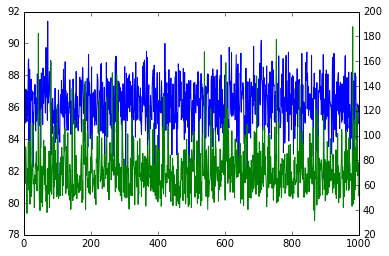

Kernel density estimator for mu:


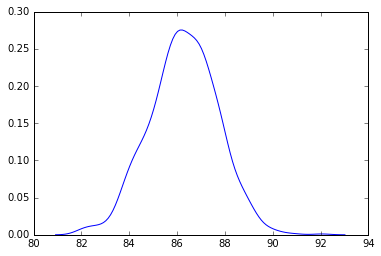

Kernel density estimator for sig2:


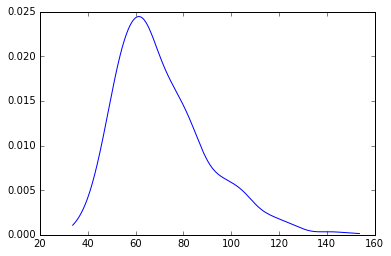

Kernel density estimator of sampled scores:


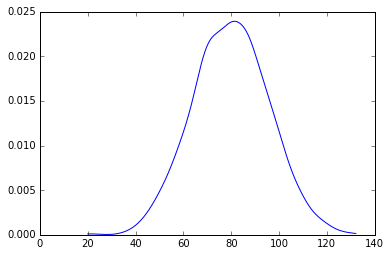

In [20]:
exam_scores = np.loadtxt("examscores.csv")

def gibbs(y, mu0, sigma02, alpha, beta, n_samples):
    """
    Assuming a likelihood and priors
        y_i ~ N(mu, sigma2),
        mu ~ N(mu0, sigma02),
        sigma2 ~ IG(alpha, beta),
    sample from the posterior distribution
        P(mu, sigma2 | y, mu0, sigma02, alpha, beta)
        using a gibbs sampler.

    Parameters
    ----------
    y : ndarray of shape (N,)
        The data
    mu0 : float
        The prior mean parameter for mu
    sigma02 : float > 0
        The prior variance parameter for mu
    alpha : float > 0
        The prior alpha parameter for sigma2
    beta : float > 0
        The prior beta parameter for sigma2
    n_samples : int
        The number of samples to draw

    Returns
    -------
    samples : ndarray of shape (n_samples,2)
        1st col = mu samples, 2nd col = sigma2 samples
    """

    # initialization steps (including randomly initialize x1,...,xn)
    Sig2 = np.empty(n_samples)
    sig2 = 50
    
    Mu = np.empty(n_samples)
    mu = np.mean(y)
    N = y.shape[0]
    
    for k in xrange(n_samples):
        #for i in xrange(n_samples):
            # Draw x from P(x_i|x_-i,y) and fix x_i = x
        # x(k) = (x1,...,xn)
        
        sig2s = 1./(1./sigma02 + N/sig2)
        mus = sig2s*(mu0/sigma02 + 1/sig2*y.sum())
        mu = norm.rvs(mus, scale=sqrt(sig2s))
        Mu[k] = mu
        
        alphas = alpha + N/2.
        betas = beta + 0.5*((y-mu)**2).sum()
        sig2 = invgamma.rvs(alphas, scale=betas)
        Sig2[k] = sig2
        
    return np.vstack((Mu,Sig2)).T

def prob1():
    samples = gibbs(exam_scores,80,16,3,50,1000)
    mu_samples = samples[:,0]
    sig2_samples = samples[:,1]
    
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1000), mu_samples, c='b')
    
    ax2 = ax1.twinx()
    ax2.plot(np.arange(1000), sig2_samples, c='g')
    plt.show()
    
def prob2():
    samples = gibbs(exam_scores,80,16,3,50,1000)
    mu_samples = samples[:,0]
    sig2_samples = samples[:,1]
    
    print "Kernel density estimator for mu:"
    mu_kernel = gaussian_kde(mu_samples)
    x_min = min(mu_samples) - 1
    x_max = max(mu_samples) + 1
    x = np.arange(x_min, x_max, step=0.1)
    plt.plot(x,mu_kernel(x))
    plt.show()
    
    print "Kernel density estimator for sig2:"
    sig_kernel = gaussian_kde(sig2_samples)
    x_min = min(sig2_samples) - 1
    x_max = max(sig2_samples) + 1
    x = np.arange(x_min, x_max, step=0.1)
    plt.plot(x,sig_kernel(x))
    plt.show()
    
def prob3():
    samples = gibbs(exam_scores,80,16,3,50,1000)
    mu_samples = samples[:,0]
    sig2_samples = samples[:,1]
    
    #y_samples = norm.rvs(mu_samples,sig2_samples,size=1000)
    y_samples = norm.rvs(80,16,size=1000)
    
    print "Kernel density estimator of sampled scores:"
    y_kernel = gaussian_kde(y_samples)
    x_min = min(y_samples) - 1
    x_max = max(y_samples) + 1
    x = np.arange(x_min, x_max, step=0.1)
    plt.plot(x,y_kernel(x))
    plt.show()
    
prob1()
prob2()
prob3()

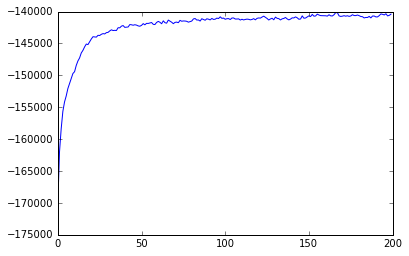

Burn-in period appears to be about 25-50 iterations.


TypeError: 'instancemethod' object has no attribute '__getitem__'

In [28]:
def loadStopwords(filename):
    """ This function is given. """
    infile = open(filename,'r')
    stopwords = infile.readlines()
    for i in xrange(len(stopwords)):
        stopwords[i] = stopwords[i].rstrip()
    stopwords.append('')
    return stopwords

class LDACGS(object):

    def __init__(self, n_topics, alpha = 0.1, beta = 0.1):
        """ This function is given. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self,filename,stopwords=None):
        """ This function is given. """
        infile = open(filename,'r')
        doclines = [line.rstrip().translate(string.maketrans("",""),string.punctuation).lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = []
        for i in xrange(n_docs):
            self.vocab += doclines[i]
        self.vocab = list(set(self.vocab))
        if stopwords != None:
            self.vocab = np.sort(self._removeStopwords(stopwords)).tolist()
        self.documents = []
        for i in xrange(n_docs):
            self.documents.append({})
            for j in xrange(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)

        # initialize the three count matrices
        # the (i,j) entry of self.nmz is # of words in document i assigned to topic j
        self.nmz = np.zeros((self.n_docs,self.n_topics))
        # the (i,j) entry of self.nzw is # of times term j is assigned to topic i
        self.nzw = np.zeros((self.n_topics,self.n_words))
        # the (i)-th entry is the number of times topic i is assigned in the corpus
        self.nz = np.zeros(self.n_topics)

        # initialize the topic assignment dictionary
        self.topics = {} # key-value pairs of form (m,i):z
        random_distribution = sp.ones(self.n_topics)/float(self.n_topics)
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                # Increment count matrices
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                z = sp.random.multinomial(1,random_distribution).argmax()
                self.nzw[z,self.documents[m][i]] += 1
                self.nmz[m,z] += 1
                self.nz[z] += 1
                self.topics[(m,i)] = z

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords=None):
        self.buildCorpus(filename,stopwords)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics,self.n_words))
        self.total_nmz = np.zeros((self.n_docs,self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in xrange(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
            #print "Iteration: {}".format(i) + "\tLog-prob: {}".format(self.logprobs[i])
        for i in xrange(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            #print "Iteration: {}".format(i+burnin) + "\tLog-prob: {}".format(self.logprobs[i+burnin])
            if not i%sample_rate:
                # accumulate counts
                self.total_nzw += sp.copy(self.nzw)
                self.total_nmz += sp.copy(self.nmz)


    def _phi(self):
        """ This function is given. """
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def _theta(self):
        """ This function is given. """
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        """ This function is given. """
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in xrange(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in xrange(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        """ This function is given. """
        lines = np.zeros((self.n_topics,n_lines))
        for i in xrange(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self,stopwords):
        """ This function is given. """
        output = []
        for x in self.vocab:
            if x not in stopwords:
                output.append(x)
        return output

    def _conditional(self, m, w):
        """
        This function is given. Compute the conditional distribution of
        the topic corresponding to document m and word index w.
        Returns a distribution vector of length self.n_topics.
        """
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist/sum(dist)

    def _sweep(self):
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i^th word in document m
                # Retrieve topic assignment for i^th word in document m
                # Decrement count matrices
                # Get conditional distribution
                # Sample new topic assignment
                # Increment count matrices
                # Store new topic assignment
                w = self.documents[m][i]
                z = self.topics[(m,i)]
                self.nzw[z,w] -= 1
                self.nmz[m,z] -= 1
                self.nz[z] -= 1
                
                z = sp.random.multinomial(1,self._conditional(m,w)).argmax()

                self.nzw[z,w] += 1
                self.nmz[m,z] += 1
                self.nz[z] += 1
                self.topics[(m,i)] = z

    def _loglikelihood(self):
        """ This function is given. """
        lik = 0

        for z in xrange(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in xrange(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

def prob7():
    obj = LDACGS(20)
    
    stops = loadStopwords('stopwords.txt')
    obj.sample('reagan.txt',stopwords=stops)
    probs = obj.logprobs
    plt.plot(probs)
    plt.show()
    
    print "Burn-in period appears to be about 25-50 iterations."
    
    print obj.topterms()
    print obj.toplines()
    
prob7()

Notice that the code provided to investigate the top topics is not working, which is not my fault. I tried, and I've got the rest of it done.